# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract cell activity and trial variables form simulation results

In [4]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
task_input = np.zeros((2, n_trials))
v1v2_values = np.zeros((2, n_trials))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rMD = np.array(data["network_rates"]["r_MD"])
        rMD_trials[idx,:,:] = rMD
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        v1v2_values[:,idx] = trial_task_input[2:]


# Compute logistic regression clustering

## Utility functions

In [58]:
def sample_trials_(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return random.sample(trials_to_sample, n_samples)

def sample_trials():
    alevel_90_idxs = [0, 2, 4, 8, 10]
    alevel_10_idxs = [1, 5, 11]
    alevel_70_idxs = [3, 6]
    alevel_30_idxs = [7]
    alevel_50_idxs = [9]

    alevel_90_trials = sample_trials_(alevel_90_idxs, 100)
    alevel_10_trials = sample_trials_(alevel_10_idxs, 100)
    alevel_70_trials = sample_trials_(alevel_70_idxs, 100)
    alevel_30_trials = sample_trials_(alevel_30_idxs, 100)
    alevel_50_trials = sample_trials_(alevel_50_idxs, 200)
    trials = alevel_90_trials + alevel_10_trials + alevel_70_trials + alevel_30_trials + alevel_50_trials
    return trials
    
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable

def linear_regression(X, y):    
    model_fit = sm.OLS(y, X).fit()
    
    # Plotting for debugging
#     plt.scatter(X[:,1], y)
#     x_fitline = np.linspace(min(X[:,1]),max(X[:,1]),10)
#     y_fitline = 1.2812 * x_fitline + 0.1760
#     plt.plot(x_fitline, y_fitline, '-r')
#     plt.show()

    return model_fit.rsquared

In [62]:
# N_PFC_NEURONS = 500
CUE_TIME = 100

SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/031021_v1-cue-breakdown'
    
rsquareds = np.zeros((N_PFC_NEURONS, 2))  
for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    trials = sample_trials()
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    cue = task_input[0, trials]
    v1  = v1v2_values[0, trials]
    MD1 = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1))
    neuron_activity = np.mean(rPFC_trials[trials, cuetime_s:cuetime_t, neuron_idx],1)
    
    # Compute linear regression
    X = np.transpose([np.ones(len(neuron_activity)), neuron_activity])
    rsquared_cue = logistic_regression(X, cue)
    rsquared_v1  = linear_regression(X, v1)
    rsquared_MD1 = logistic_regression(X, MD1)
#     rsquareds[neuron_idx,:] = [rsquared_cue, rsquared_v1]

    neuron_all = np.mean(rPFC_trials[:, cuetime_s:cuetime_t, neuron_idx],1)
    v1_all = v1v2_values[0,:]

    b_cue1 = cue.astype(bool)
    b_MD1 = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1)).astype(bool)

    
    plt.figure(figsize=(10,7))
    
    trials_90_cue1_MD1 = np.array(trials[0:100])[b_cue1[0:100] * b_MD1[0:100]]
    trials_90_cue1_MD0 = np.array(trials[0:100])[b_cue1[0:100] * np.invert(b_MD1[0:100])]
    plt.scatter(neuron_all[trials_90_cue1_MD1], v1_all[trials_90_cue1_MD1], color='b', marker="^", alpha=0.5, s=80, label=".9")
    plt.scatter(neuron_all[trials_90_cue1_MD0], v1_all[trials_90_cue1_MD0], color='b', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_90_cue0_MD1 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * b_MD1[0:100]]
    trials_90_cue0_MD0 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * np.invert(b_MD1[0:100])]
    plt.scatter(neuron_all[trials_90_cue0_MD1], v1_all[trials_90_cue0_MD1], color='b', marker="<", alpha=0.5, s=80)
    plt.scatter(neuron_all[trials_90_cue0_MD0], v1_all[trials_90_cue0_MD0], color='b', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue1_MD1 = np.array(trials[100:200])[b_cue1[100:200] * b_MD1[100:200]]
    trials_10_cue1_MD0 = np.array(trials[100:200])[b_cue1[100:200] * np.invert(b_MD1[100:200])]
    plt.scatter(neuron_all[trials_10_cue1_MD1], v1_all[trials_10_cue1_MD1], color='g', marker="^", alpha=0.5, s=80, label=".1")
    plt.scatter(neuron_all[trials_10_cue1_MD0], v1_all[trials_10_cue1_MD0], color='g', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue0_MD1 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * b_MD1[100:200]]
    trials_10_cue0_MD0 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * np.invert(b_MD1[100:200])]
    plt.scatter(neuron_all[trials_10_cue0_MD1], v1_all[trials_10_cue0_MD1], color='g', marker="<", alpha=0.5, s=80)
    plt.scatter(neuron_all[trials_10_cue0_MD0], v1_all[trials_10_cue0_MD0], color='g', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue1_MD1 = np.array(trials[200:300])[b_cue1[200:300] * b_MD1[200:300]]
    trials_70_cue1_MD0 = np.array(trials[200:300])[b_cue1[200:300] * np.invert(b_MD1[200:300])]
    plt.scatter(neuron_all[trials_70_cue1_MD1], v1_all[trials_70_cue1_MD1], color='r', marker="^", alpha=0.5, s=80, label=".7")
    plt.scatter(neuron_all[trials_70_cue1_MD0], v1_all[trials_70_cue1_MD0], color='r', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue0_MD1 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * b_MD1[200:300]]
    trials_70_cue0_MD0 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * np.invert(b_MD1[200:300])]
    plt.scatter(neuron_all[trials_70_cue0_MD1], v1_all[trials_70_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    plt.scatter(neuron_all[trials_70_cue0_MD0], v1_all[trials_70_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue1_MD1 = np.array(trials[300:400])[b_cue1[300:400] * b_MD1[300:400]]
    trials_30_cue1_MD0 = np.array(trials[300:400])[b_cue1[300:400] * np.invert(b_MD1[300:400])]
    plt.scatter(neuron_all[trials_30_cue1_MD1], v1_all[trials_30_cue1_MD1], color='c', marker="^", alpha=0.5, s=80, label=".3")
    plt.scatter(neuron_all[trials_30_cue1_MD0], v1_all[trials_30_cue1_MD0], color='c', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue0_MD1 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * b_MD1[300:400]]
    trials_30_cue0_MD0 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * np.invert(b_MD1[300:400])]
    plt.scatter(neuron_all[trials_30_cue0_MD1], v1_all[trials_30_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    plt.scatter(neuron_all[trials_30_cue0_MD0], v1_all[trials_30_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_50_cue1_MD1 = np.array(trials[400:600])[b_cue1[400:600] * b_MD1[400:600]]
    trials_50_cue1_MD0 = np.array(trials[400:600])[b_cue1[400:600] * np.invert(b_MD1[400:600])]
    plt.scatter(neuron_all[trials_50_cue1_MD1], v1_all[trials_50_cue1_MD1], color='m', marker="^", alpha=0.5, s=80, label=".5")
    plt.scatter(neuron_all[trials_50_cue1_MD0], v1_all[trials_50_cue1_MD0], color='m', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_50_cue0_MD1 = np.array(trials[400:600])[np.invert(b_cue1[400:600]) * b_MD1[400:600]]
    trials_50_cue0_MD0 = np.array(trials[400:600])[np.invert(b_cue1[400:600]) * np.invert(b_MD1[400:600])]
    plt.scatter(neuron_all[trials_50_cue0_MD1], v1_all[trials_50_cue0_MD1], color='m', marker="<", alpha=0.5, s=80)
    plt.scatter(neuron_all[trials_50_cue0_MD0], v1_all[trials_50_cue0_MD0], color='m', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')
    
    plt.xlabel('PFC activity')
    plt.ylabel('V1 value')
    plt.legend()
    plt.title(f"Neuron {neuron_idx}, R^2 cue = {np.round(rsquared_cue,3)}, R^2 V1 = {np.round(rsquared_v1,3)}, R^2 MD1 = {np.round(rsquared_MD1,3)}")
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()    
    
# plt.scatter(rsquareds[:,0], rsquareds[:,1])
# plt.xlabel('R^2 cue')
# plt.ylabel('R^2 v1')
# plt.title('Regression analysis of PFC vs cue and PFC vs V1')
# plt.show()

Optimization terminated successfully.
         Current function value: 0.633519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.271853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006554
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.677135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.451709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036150
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.642252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.261003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.614241

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.235213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.215606
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360179
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.246170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.545885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689659
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.167957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.581552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290418
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.292835
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.630730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485375
  

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.315884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.417453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.480664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.564991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013759
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.677903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686744
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.485605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.431920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624141
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.019536
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.678336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.433466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681735
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.580410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673620
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017584
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.685859
         Iterations 4
Optimization terminated successfully.
         Current functi

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.292905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.483736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082078
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.540968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590357
 

Optimization terminated successfully.
         Current function value: 0.414520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.550180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562941


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.680143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.390678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692056
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.146676
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649350
  

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.683694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.343473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.558883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370978
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.540470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097871
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680495
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.683728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.453484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092010
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.517328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.292258
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.272882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683543


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.691721
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.411811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086056
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.641711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.431922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.059048
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.386250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057065
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.641806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627362
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.690395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.571046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.280161
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.069764
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.556291
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.633054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.026950
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.675509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.142837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.556195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665009


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.014471
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.635693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692975
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.603221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.230279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.547195
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.011719
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.681549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.177225
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.565402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.163966
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.377964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.401481

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.684205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582763
         Iterations 5
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661536
         Iterations 4


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.679782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.237827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.611403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658823
  

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.617338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006094
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.672066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.229257
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.595616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372773
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685255


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.641251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.518561
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654371
         Iterations 5


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.679869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.310964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.106094
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626792
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567339
         Iterations 6


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.622938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.443488
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.302036
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.691578
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.208073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667366
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.306551
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655564
         Iterations 5


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.469020
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.424786
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.643749
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559821
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590112
         Iterations 6


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.624821
         Iterations 5
         Current function value: 0.087748
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.577213
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680104
         Iterations 5
         Current function value: 0.468382
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.668430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.072580
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.553998
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.598554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.322089
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.276780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688115


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.679141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.403083
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594138
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.354970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599277
         Iterations 12


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.661390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620577
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674970
         Iterations 4
         Current function value: 0.474609
         Iterations: 50
         Current function value: 0.460813
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.478953
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.484002
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.308722
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603640
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.547221
         Iterations 7
         Current function value: 0.240836
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.673866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.456447
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637833
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.688825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563564
         Iterations 6
         Current function value: 0.373312
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.590530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050575
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.614907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421894
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.646206
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization termin

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.660126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430184
         Iterations 6
         Current function value: 0.587410
         Iterations: 50
         Current function value: inf
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.437228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.490040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.552165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.530992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014866
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.683264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.490767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.281936
         Iterations 13
         Current function value: 0.662922
         Iterations: 50
         Current function value: 0.661694
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.692375
         Iterations 3
         Current function value: 0.020355
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.683560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.544692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.535999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.541438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585889
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current fu

(array([99., 22., 25., 19., 22., 21., 16., 10., 16.,  7., 11.,  8., 10.,
        13., 11., 10., 10., 11., 10., 11.,  4.,  4.,  7.,  7.,  7., 11.,
         9.,  4., 13.,  5.,  5.,  7.,  4.,  8.,  3.,  6.,  3.,  6.,  2.,
         6.,  2.,  2.,  2.,  1.,  3.,  1.,  3.,  1.,  1.,  1.]),
 array([7.61794662e-06, 1.84094946e-02, 3.68113713e-02, 5.52132480e-02,
        7.36151247e-02, 9.20170014e-02, 1.10418878e-01, 1.28820755e-01,
        1.47222631e-01, 1.65624508e-01, 1.84026385e-01, 2.02428262e-01,
        2.20830138e-01, 2.39232015e-01, 2.57633892e-01, 2.76035768e-01,
        2.94437645e-01, 3.12839522e-01, 3.31241398e-01, 3.49643275e-01,
        3.68045152e-01, 3.86447029e-01, 4.04848905e-01, 4.23250782e-01,
        4.41652659e-01, 4.60054535e-01, 4.78456412e-01, 4.96858289e-01,
        5.15260165e-01, 5.33662042e-01, 5.52063919e-01, 5.70465795e-01,
        5.88867672e-01, 6.07269549e-01, 6.25671426e-01, 6.44073302e-01,
        6.62475179e-01, 6.80877056e-01, 6.99278932e-01, 7.17680809e-

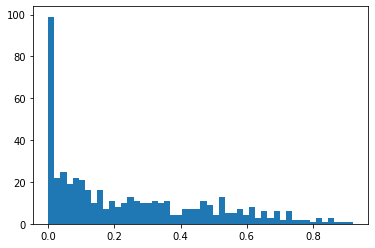

In [85]:
plt.hist(rsquareds[:,1], bins=50)
plt.title('R^2 V1 vs PFC activity histogram')